In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # data visualization library  
from functools import reduce
import xgboost
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "../NCAA-2018-Prediction/Data Files"
import os
print(os.listdir(path))

# Any results you write to the current directory are saved as output.

['SampleSubmissionStage2.csv', 'SampleSubmissionStage1.csv', '.DS_Store', 'Teams.csv', 'TeamConferences.csv', 'NCAATourneySeeds.csv', 'SecondaryTourneyTeams.csv', 'NCAATourneySeedRoundSlots.csv', 'RegularSeasonDetailedResults.csv', 'RegularSeasonCompactResults.csv', 'TeamCoaches.csv', 'Cities.csv', 'SecondaryTourneyCompactResults.csv', 'GameCities.csv', 'TeamSpellings.csv', 'Seasons.csv', 'MasseyOrdinals.csv', 'ConferenceTourneyGames.csv', 'Conferences.csv', 'NCAATourneySlots.csv', 'NCAATourneyCompactResults.csv', 'NCAATourneyDetailedResults.csv']


In [60]:
NCAATourneySeeds = pd.read_csv(path + '/NCAATourneySeeds.csv')
NCAATourneyDetailedResults = pd.read_csv(path + '/NCAATourneyDetailedResults.csv')
RegularSeasonCompactResults = pd.read_csv(path + '/RegularSeasonCompactResults.csv')
RegularSeasonDetailedResults = pd.read_csv(path + '/RegularSeasonDetailedResults.csv')
Teams = pd.read_csv(path + '/Teams.csv')
Seasons = pd.read_csv(path + '/Seasons.csv')
MasseyOrdinals = pd.read_csv(path + '/MasseyOrdinals.csv')
SampleSubmissionStage1 = pd.read_csv(path + '/SampleSubmissionStage1.csv')
ordinal = pd.read_csv(path + '/MasseyOrdinals.csv')
ordinal_rank = pd.DataFrame({'Avgrank' : ordinal[ordinal['RankingDayNum'] == 133].groupby(['Season','TeamID'])['OrdinalRank'].mean()}).reset_index()

In [61]:
def add_feature(inputdf):
    outdf = inputdf.copy()
    outdf['WFGpct'] = outdf['WFGM']/outdf['WFGA']
    outdf['LFGpct'] = outdf['LFGM']/outdf['LFGA']
    outdf['WFGpct3'] = outdf['WFGM3']/outdf['WFGA3']
    outdf['LFGpct3'] = outdf['LFGM3']/outdf['LFGA3']
    outdf['WDefRtg'] = 100 * outdf['LScore']/(outdf['LFGA'] + 0.475 * outdf['LFTA'] - outdf['LOR'] + outdf['LTO'])
    outdf['LDefRtg'] = 100 * outdf['WScore']/(outdf['WFGA'] + 0.475 * outdf['WFTA'] - outdf['WOR'] + outdf['WTO'])
#     outdf['WFTpct'] = outdf['WFTM']/outdf['WFTA']
#     outdf[np.isinf(outdf['WFTpct']) == True] = None
#     outdf['LFTpct'] = outdf['LFTM']/outdf['LFTA']
#     outdf[np.isinf(outdf['LFTpct']) == True] = None
    outdf['WAT'] = outdf['WAst']/outdf['WTO']
    outdf['LAT'] = outdf['LAst']/outdf['LTO']
    outdf[np.isinf(outdf['LAT']) == True] = None
    outdf['Part1'] = outdf['WFGA'] + 0.4* outdf['WFTA'] - 1.07 * (outdf['WOR']/(outdf['WOR'] + outdf['LDR'])) * (outdf['WFGA'] - outdf['WFGM']) + outdf['WTO']
    outdf['Part2'] = outdf['LFGA'] + 0.4* outdf['LFTA'] - 1.07 * (outdf['LOR']/(outdf['LOR'] + outdf['WDR'])) * (outdf['LFGA'] - outdf['LFGM']) + outdf['LTO']
    outdf['WOffRtg'] = 100 * outdf['WScore'] / (0.5* (outdf['Part1'] + outdf['Part2']))
    outdf = outdf.drop(['Part1','Part2'],axis=1)
    outdf['Part1'] = outdf['LFGA'] + 0.4* outdf['LFTA'] - 1.07 * (outdf['LOR']/(outdf['LOR'] + outdf['WDR'])) * (outdf['LFGA'] - outdf['LFGM']) + outdf['LTO']
    outdf['Part2'] = outdf['WFGA'] + 0.4* outdf['WFTA'] - 1.07 * (outdf['WOR']/(outdf['WOR'] + outdf['LDR'])) * (outdf['WFGA'] - outdf['WFGM']) + outdf['WTO']
    outdf['LOffRtg'] = 100 * outdf['LScore'] / (0.5* (outdf['Part1'] + outdf['Part2']))
    outdf = outdf.drop(['Part1','Part2'],axis=1)
    outdf = outdf[np.isfinite(outdf['Season'])]
    return outdf

In [62]:
def stat_table(inputdf, var):
    df = inputdf
    df['W'] = df['W' + var]
    df['L'] = df['L' + var]

    W = df.groupby(['Season','WTeamID'])['W'].agg(['sum','count'])
    W = W.reset_index().rename(columns={'sum':'Wsum','count':'Wcount','WTeamID':'TeamID'})
    L = df.groupby(['Season','LTeamID'])['L'].agg(['sum','count'])
    L = L.reset_index().rename(columns={'sum':'Lsum','count':'Lcount','LTeamID':'TeamID'})
    stat = pd.merge(W,L,left_on=['Season','TeamID'],right_on=['Season','TeamID'],how='inner')
    stat['sum'] = stat['Wsum'] + stat['Lsum']
    stat['count'] = stat['Wcount'] + stat['Lcount']
    stat['Avg'+var] = stat['sum']/stat['count']
    stat = stat[['Season','TeamID','Avg'+var]]
    return stat

def add_diff(inputdf, statdf, var):
    if (var != 'seed_int'):
        df = inputdf.merge(statdf[['Season','TeamID','Avg'+var]],left_on=['Season','WTeamID'],right_on=['Season','TeamID'],how='left')
        df2 = df.drop('TeamID',axis=1).rename(columns={'Avg'+var:'WAvg'+var})
        df3 = df2.merge(statdf[['Season','TeamID','Avg'+var]],left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='left')
        outputdf = df3.drop('TeamID',axis=1).rename(columns={'Avg'+var:'LAvg'+var})
        outputdf['Diff'+var] = outputdf['WAvg'+var] - outputdf['LAvg'+var]
        outputdf = outputdf.drop(['WAvg'+var,'LAvg'+var], axis = 1)
    else:
        df = inputdf.merge(statdf[['Season','TeamID',var]],left_on=['Season','WTeamID'],right_on=['Season','TeamID'],how='left')
        df2 = df.drop('TeamID',axis=1).rename(columns={var:'W'+var})
        df3 = df2.merge(statdf[['Season','TeamID',var]],left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='left')
        outputdf = df3.drop('TeamID',axis=1).rename(columns={var:'L'+var})
        outputdf['Diff'+var] = outputdf['W'+var] - outputdf['L'+var]
        outputdf = outputdf.drop(['W'+var,'L'+var], axis = 1)
    return outputdf

In [63]:
df = pd.concat([RegularSeasonDetailedResults, NCAATourneyDetailedResults])
finaldf = add_feature(inputdf = df)
finaldf['target'] = 1
ast = stat_table(finaldf, var = 'Ast')
to = stat_table(finaldf, var = 'TO')
fga = stat_table(finaldf, var = 'FGA')
fga3 = stat_table(finaldf, var = 'FGA3')
fgpct = stat_table(finaldf, var = 'FGpct')
fgpct3 = stat_table(finaldf, var = 'FGpct3')
# ftpct = stat_table(finaldf, var = 'FTpct')
at = stat_table(finaldf, var = 'AT')
offreb = stat_table(finaldf, var = 'OR')
defreb = stat_table(finaldf, var = 'DR')
offrtg = stat_table(finaldf, var = 'OffRtg')
defrtg = stat_table(finaldf, var = 'DefRtg')
dfs = [ast,to,fga,fga3,fgpct,fgpct3
#        ,ftpct
       ,at,offreb,defreb,offrtg,defrtg]
stat_final = reduce(lambda left,right: pd.merge(left,right,on=['Season','TeamID']), dfs)

# Manual add
# stat_add1 = stat_final[(stat_final['Season'] == 2013) & (stat_final['TeamID'] == 1455)].copy()
# stat_add2 = stat_final[(stat_final['Season'] == 2014) & (stat_final['TeamID'] == 1246)].copy()
# stat_add1.loc[:,'Season'] = 2014
# stat_add2.loc[:,'Season'] = 2015
# frames = [stat_final, stat_add1, stat_add2]
# stat_final = pd.concat(frames)

In [65]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds = NCAATourneySeeds.copy()
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [66]:
stat_final = stat_final.merge(df_seeds, left_on=['Season','TeamID'], right_on=['Season','TeamID'], how='left')
stat_final['seed_int'].fillna(0,inplace=True)
stat_final = stat_final.merge(ordinal_rank, left_on=['Season','TeamID'], right_on=['Season','TeamID'], how='left')
stat_final['Avgrank'].fillna(0,inplace=True)

In [67]:
finaldf = add_diff(finaldf, stat_final, 'Ast')
finaldf = add_diff(finaldf, stat_final, 'TO')
finaldf = add_diff(finaldf, stat_final, 'FGA')
finaldf = add_diff(finaldf, stat_final, 'FGA3')
finaldf = add_diff(finaldf, stat_final, 'FGpct')
finaldf = add_diff(finaldf, stat_final, 'FGpct3')
# finaldf = add_diff(finaldf, stat_final, 'FTpct')
finaldf = add_diff(finaldf, stat_final, 'AT')
finaldf = add_diff(finaldf, stat_final, 'OR')
finaldf = add_diff(finaldf, stat_final, 'DR')
finaldf = add_diff(finaldf, stat_final, 'OffRtg')
finaldf = add_diff(finaldf, stat_final, 'DefRtg')
finaldf = add_diff(finaldf, stat_final, 'seed_int')
finaldf = add_diff(finaldf, stat_final, 'rank')
finaldf = finaldf.drop(['W','L'], axis = 1)

In [68]:
finaldf = finaldf.dropna(how='any')

In [69]:
finaldf['weight'] = 1
finaldf.loc[finaldf[finaldf['DayNum'] >= 136].index,'weight'] = 100

In [70]:
train_data = finaldf[['target','weight'
                      ,'WLoc','Diffrank'
#                       ,'Diffseed_int'
                      ,'DiffAst','DiffTO'
#                       ,'DiffFGpct'
                      ,'DiffFGpct3'
                      ,'DiffFGA','DiffFGA3'
#                       ,'DiffFTpct'
#                       ,'DiffAT'
                      ,'DiffOffRtg','DiffDefRtg'
                     ]]

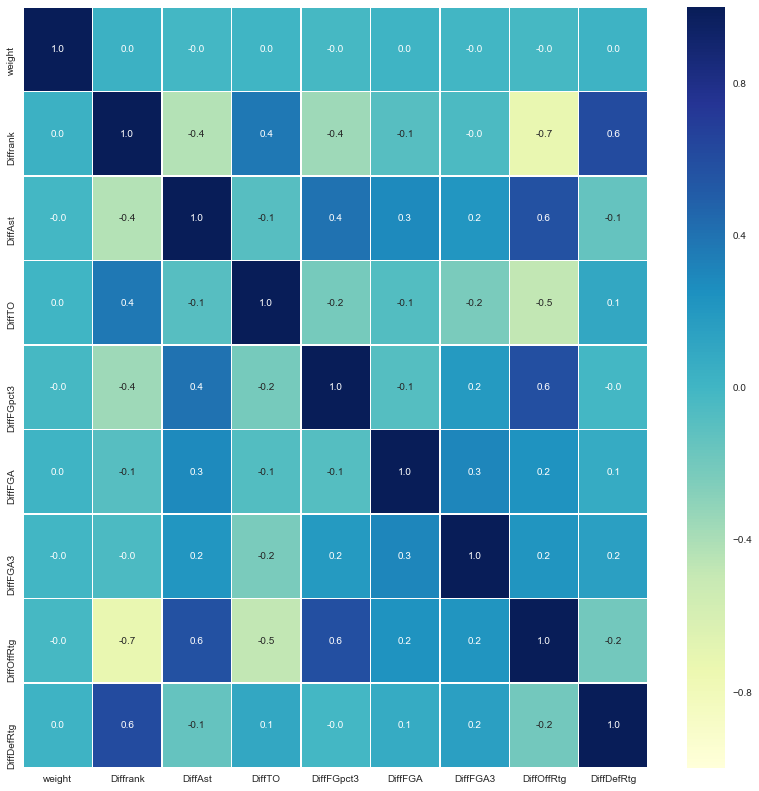

In [71]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(train_data.loc[:, train_data.columns != 'target'].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax , cmap="YlGnBu")

In [72]:
train0= train_data.sample(frac=0.5,random_state=200)
train1= train_data.drop(train0.index)
train0_X = train0.loc[:, ~train0.columns.isin(['target','weight'])]
train0_X_num = train0_X.loc[:, train0_X.columns != 'WLoc']
train0_X_cat = train0_X.loc[:, train0_X.columns == 'WLoc']
train0_w = train0.loc[:, train0.columns == 'weight']
train0_y = train0.loc[:, train0.columns == 'target']

In [73]:
train0_X_num = train0_X_num.apply(lambda x: x*-1)
train0_X_cat = train0_X_cat.replace('A','X')
train0_X_cat = train0_X_cat.replace('H','A')
train0_X_cat = train0_X_cat.replace('X','H')
train0_y = train0_y.apply(lambda x: x*0)

In [74]:
train0_X = pd.concat([train0_X_cat, train0_X_num], axis = 1)
train0 = pd.concat([train0_y, train0_w, train0_X], axis = 1)
train_data = pd.concat([train0, train1], axis = 0)

train_data = pd.get_dummies(train_data)
train_data.rename(columns={'WLoc_A':'Loc_A','WLoc_H':'Loc_H','WLoc_N':'Loc_N'},inplace=True)
train_data.drop(['Loc_N'], axis = 1, inplace= True)

# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# enc.fit(train_data['WLoc'])
# enc.transform(train_data)

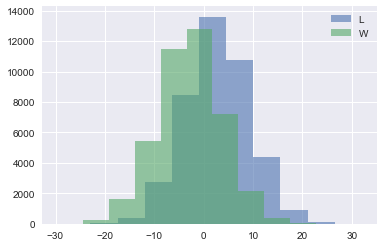

In [75]:
def plot_hist(var):
    df_graph = train_data[[var,'target']]
    plt.hist(df_graph[df_graph["target"]== 0][var].reset_index(drop=True), alpha=0.6, label="L")
    plt.hist(df_graph[df_graph["target"]==1][var].reset_index(drop=True), alpha=0.6, label="W")
    plt.legend()
    plt.show()
plot_hist('DiffDefRtg')

In [76]:
X = train_data.iloc[:, 2:]
w = train_data.iloc[:, 1]
y = train_data.iloc[:, 0]

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size = 0.2, random_state = 0)

# Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [78]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()      
clr_rf = clf_rf.fit(X_train,y_train)
importances = clr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.331119)
2. feature 7 (0.117450)
3. feature 6 (0.112993)
4. feature 1 (0.078397)
5. feature 2 (0.075693)
6. feature 3 (0.074651)
7. feature 4 (0.073728)
8. feature 5 (0.073651)
9. feature 9 (0.038332)
10. feature 8 (0.023986)


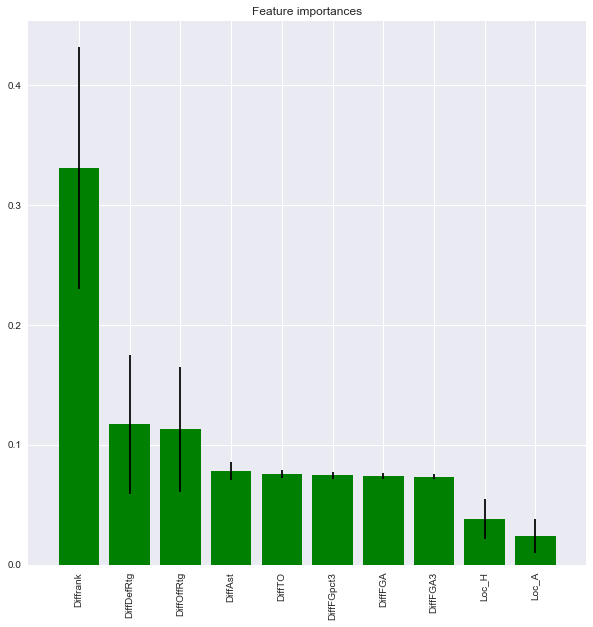

In [79]:
# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [80]:
from sklearn.feature_selection import RFE

# The "accuracy" scoring is proportional to the number of correct classifications
# y = column_or_1d(y_train_pd,warn=True)
clf_rf = RandomForestClassifier() 
rfe = RFE(estimator=clf_rf, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

from sklearn.feature_selection import RFECV

clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Chosen best 5 feature by rfe: Index(['Diffrank', 'DiffAst', 'DiffTO', 'DiffOffRtg', 'DiffDefRtg'], dtype='object')
Optimal number of features : 10
Best features : Index(['Diffrank', 'DiffAst', 'DiffTO', 'DiffFGpct3', 'DiffFGA', 'DiffFGA3',
       'DiffOffRtg', 'DiffDefRtg', 'Loc_A', 'Loc_H'],
      dtype='object')


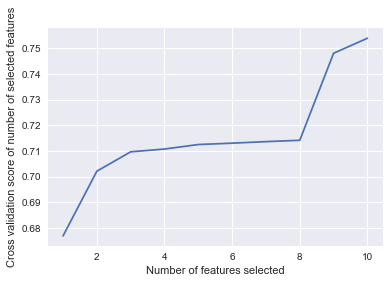

In [81]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [82]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(random_state = 0)
# classifier.fit(X_train, y_train, sample_weight=w_train)

# classifier = LogisticRegression()
# params = {'C': np.logspace(start=-5, stop=3, num=9)}
# classifier = GridSearchCV(classifier, params, scoring='neg_log_loss', refit=True)
# classifier.fit(X_train, y_train, sample_weight=w_train)

# Fitting Random Forest Classification to the Training set
# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
# classifier.fit(X_train, y_train, w_train)

# from sklearn.svm import SVC
# classifier = SVC(kernel = 'linear', random_state = 0)
# classifier.fit(X_train, y_train)

# from sklearn.svm import SVC
# classifier = SVC(kernel = 'rbf', random_state = 0)
# classifier.fit(X_train, y_train)

from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train, sample_weight=w_train)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print('Mean : ' , accuracies.mean())
print('Std : ' , accuracies.std())


# parameters = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
# parameters = [{'C':[0.001,0.01,0.1,1]}]
# grid_search = GridSearchCV(estimator = classifier,
#                            param_grid = parameters,
#                            scoring = 'accuracy',
#                            cv = 10,
#                            n_jobs = -1)
# grid_search = grid_search.fit(X_train, y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_

# print('best accuracy :', best_accuracy)
# print('best parameters :', best_parameters)

Mean :  0.779394816849
Std :  0.00397984149807


In [83]:
#Probability output for logistic regression
prob_pred = classifier.predict_proba(X_test)[:,1]
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('cm : ', cm)
print('Accuracy : ', (cm[0][0]+cm[1][1])/cm.sum())

cm :  [[6294 1864]
 [2022 6397]]
Accuracy :  0.765578814019


In [84]:
NCAA_data = finaldf[['target','DayNum'
                      ,'WLoc','Diffrank'
#                       ,'Diffseed_int'
                      ,'DiffAst','DiffTO'
#                       ,'DiffFGpct'
                     ,'DiffFGpct3'
                      ,'DiffFGA','DiffFGA3'
#                       ,'DiffFTpct'
#                      ,'DiffAT'
                      ,'DiffOffRtg','DiffDefRtg'
                     ]]
NCAA_data = NCAA_data[NCAA_data['DayNum'] >= 136]
NCAA_data.drop(['DayNum'], axis = 1, inplace=True)
NCAA_data = pd.get_dummies(NCAA_data)
NCAA_data.rename(columns={'WLoc_N':'Loc_N'},inplace=True)
NCAA_data['Loc_A'] = 0
NCAA_data['Loc_H'] = 0
NCAA_data.drop(['Loc_N'], axis = 1 , inplace = True)

X_NCAA = NCAA_data.iloc[:, 1:]
y_NCAA = NCAA_data.iloc[:, 0]

# X_NCAA = sc.transform(X_NCAA)

In [85]:
y_pred_NCAA = classifier.predict(X_NCAA)
cm = confusion_matrix(y_NCAA, y_pred_NCAA)
print(cm)
print('Accuracy : ', (cm[0][0]+cm[1][1])/cm.sum())

[[  0   0]
 [259 686]]
Accuracy :  0.725925925926


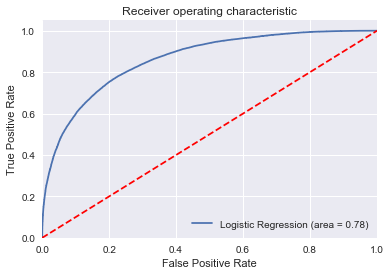

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_train, classifier.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, classifier.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [87]:
y_pred_all = classifier.predict(X)
cm = confusion_matrix(y, y_pred_all)
cm

array([[32282,  9158],
       [ 9515, 31926]])

In [88]:
SampleSubmissionStage2 = pd.read_csv(path + '/SampleSubmissionStage2.csv')
Matchup = SampleSubmissionStage2.copy()
Matchup[['Season', 'WTeamID', 'LTeamID']] = Matchup['ID'].str.split("_", expand=True)
Matchup.drop(['Pred'], axis = 1, inplace=True)
Matchup['Season'] = Matchup['Season'].astype(int)
Matchup['WTeamID'] = Matchup['WTeamID'].astype(int)
Matchup['LTeamID'] = Matchup['LTeamID'].astype(int)

In [89]:
# Matchup = NCAATourneyDetailedResults.loc[:,['Season','WTeamID','LTeamID']]
# Matchup['actual'] = 1
Matchup = add_diff(Matchup, stat_final, 'Ast')
Matchup = add_diff(Matchup, stat_final, 'TO')
Matchup = add_diff(Matchup, stat_final, 'FGA')
Matchup = add_diff(Matchup, stat_final, 'FGA3')
Matchup = add_diff(Matchup, stat_final, 'FGpct')
Matchup = add_diff(Matchup, stat_final, 'FGpct3')
# Matchup = add_diff(Matchup, stat_final, 'FTpct')
Matchup = add_diff(Matchup, stat_final, 'AT')
Matchup = add_diff(Matchup, stat_final, 'OR')
Matchup = add_diff(Matchup, stat_final, 'DR')
Matchup = add_diff(Matchup, stat_final, 'OffRtg')
Matchup = add_diff(Matchup, stat_final, 'DefRtg')
Matchup = add_diff(Matchup, stat_final, 'seed_int')
Matchup = add_diff(Matchup, stat_final, 'rank')
Matchup.rename(columns={'WTeamID':'TeamID1','LTeamID':'TeamID2'}, inplace=True)

In [90]:
# NCAA Match Up
Matchup_data = Matchup.loc[:,X_train.drop(['Loc_A','Loc_H'], axis = 1).columns]

Matchup_data['Loc_A'] = 0
Matchup_data['Loc_H'] = 0
# Matchup_data['Loc_N'] = 1

In [91]:
X_matchup = Matchup_data
# X_matchup = sc.transform(X_matchup)

In [92]:
#Output Probability
prob_pred_matchup = classifier.predict_proba(X_matchup)[:,1]
# y_pred_matchup = (prob_pred_matchup >= 0.5).astype(int)

y_pred_matchup = classifier.predict(X_matchup)

In [93]:
# pred = pd.DataFrame(data=y_pred_matchup,columns=['pred'])
pred = pd.DataFrame(data=prob_pred_matchup,columns=['pred'])

result = pd.concat([Matchup,pred], axis=1)
result = result.rename(columns={'ID':'id'})

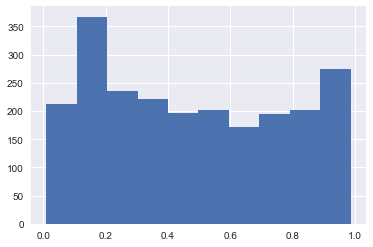

In [94]:
result['pred'].hist()

In [97]:
#Clip
result['pred'] = result['pred'].clip(0.05,0.95)

In [98]:
submit = result[['id','pred']]
submit.to_csv("NCAA_2018_v1.csv", index=False)

In [99]:
result_team = result[['TeamID1','TeamID2','pred']]
result_team1 = result_team.merge(Teams[['TeamID','TeamName']],left_on=['TeamID1'],right_on=['TeamID'],how='left')
result_team1.rename(columns={'TeamName':'Team1'}, inplace = True)
result_team2 = result_team1.merge(Teams[['TeamID','TeamName']],left_on=['TeamID2'],right_on=['TeamID'],how='left')
result_team2.rename(columns={'TeamName':'Team2'}, inplace = True)
result_team2.drop(['TeamID1','TeamID2','TeamID_x','TeamID_y'], axis = 1, inplace = True)

In [100]:
result_team2.to_csv("NCAA_2018_v1_name.csv", index=False)